<a href="https://colab.research.google.com/github/stellaw1/400q-project/blob/main/400q_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane
!pip install tensorflow==2.7.0
!pip install tensorflow-quantum==0.7.2
!pip install cirq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.7/489.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 KB 36.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Succ

ttf-mscorefonts-installer is already the newest version (3.7ubuntu6).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [2]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py'>

In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy

In [4]:
# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [5]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit

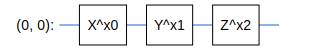

In [6]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

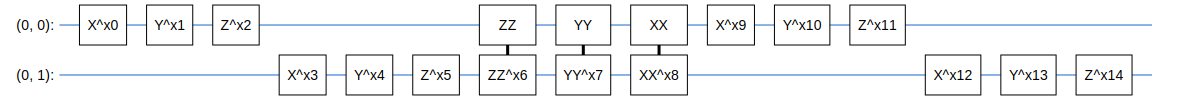

In [7]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

In [8]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

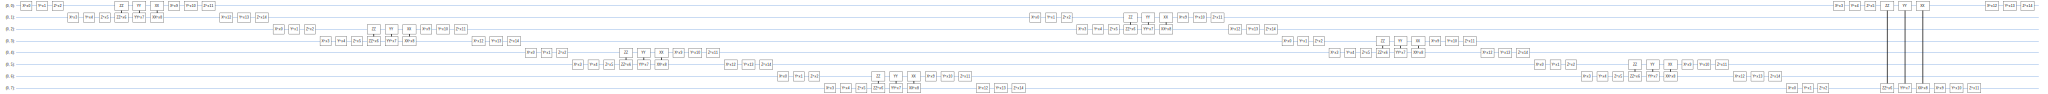

In [9]:
SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 8), sympy.symbols('x0:15')))

In [10]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]): # (0, 1) -> (2, 3) 
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]): # (1, 2) -> (3, 0)
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

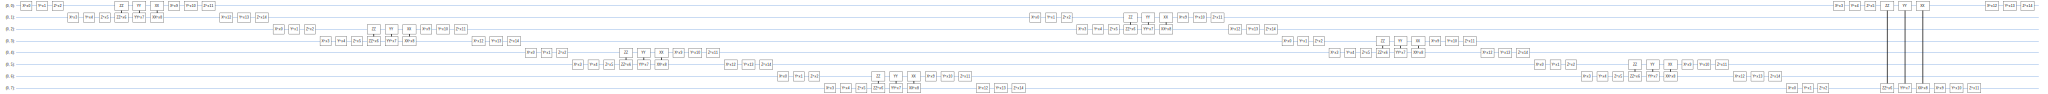

In [11]:
SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 8), sympy.symbols('x0:15')))

In [12]:
def quantum_branch_circuit(qubits, symbols):

    L = len(qubits)

    circuit = cirq.Circuit()

    # Measure 2L/3 of the input qubits
    measurement_qubits = qubits[:2*L//3]
    measurement_ops = [cirq.measure(qubit, key=f'm{idx}') for idx, qubit in enumerate(measurement_qubits)]

    circuit += measurement_ops

    # Create 2^(2L/3) branches for the remaining L/3 qubits
    remaining_qubits = qubits[2*L//3:]
    num_branches = 2 ** (2 * L // 3)

    import itertools
    branch_permutations = list(itertools.product([0, 1], repeat=2*L//3))

    for branch in range(num_branches):
        for idx, qubit in enumerate(remaining_qubits):
            control = (measurement_qubits[i] for i, b in enumerate(branch_permutations[branch]) if b)
            theta = symbols[idx * num_branches + branch]
            controlled_ry = cirq.ry(theta)(qubit).controlled_by(*(control))

            circuit += controlled_ry
    return circuit

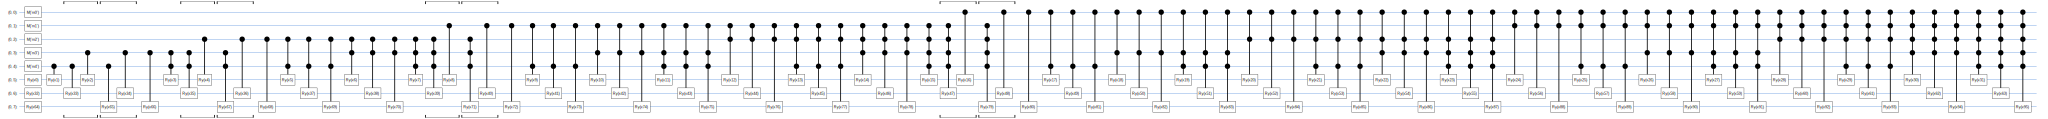

In [13]:
test_bits = cirq.GridQubit.rect(1, 8)

SVGCircuit(
    quantum_branch_circuit(test_bits, sympy.symbols('x0:96')))

In [14]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

In [20]:
def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:111')
    symbols = sympy.symbols('qconv0:237')
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_branch_circuit(qubits, symbols[15:111])
    model_circuit += quantum_conv_circuit(qubits[5:], symbols[111:126])
    model_circuit += quantum_branch_circuit(qubits[5:], symbols[126:237])
    return model_circuit

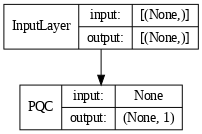

In [32]:
# Create our qubits and readout operators in Cirq.
cluster_state_bits = cirq.GridQubit.rect(1, 8)
readout_operators = cirq.Z(cluster_state_bits[-1])

# Build a sequential model enacting the logic in 1.3 of this notebook.
# Here you are making the static cluster state prep as a part of the AddCircuit and the
# "quantum datapoints" are coming in the form of excitation
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits),
                               readout_operators)(excitation_input)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

In [33]:
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 20  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)

    split_ind = int(len(excitations) * 0.7)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
        tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [35]:
# Generate some training data.
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    cluster_state_bits)


# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.losses.MAE(y_true, y_pred)


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

history = qcnn_model.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=16,
                         epochs=50,
                         verbose=1,
                         validation_data=(test_excitations, test_labels))

Epoch 1/50
7/7 [==============================] - 4s 549ms/step - loss: 0.6596 - custom_accuracy: 0.5000 - val_loss: 0.6858 - val_custom_accuracy: 0.4583
Epoch 2/50
7/7 [==============================] - 4s 567ms/step - loss: 0.6186 - custom_accuracy: 0.3036 - val_loss: 0.6427 - val_custom_accuracy: 0.6250
Epoch 3/50
7/7 [==============================] - 5s 777ms/step - loss: 0.5633 - custom_accuracy: 0.2679 - val_loss: 0.6093 - val_custom_accuracy: 0.3750
Epoch 4/50
7/7 [==============================] - 5s 807ms/step - loss: 0.5646 - custom_accuracy: 0.2143 - val_loss: 0.6275 - val_custom_accuracy: 0.4167
Epoch 5/50
7/7 [==============================] - 2s 325ms/step - loss: 0.5385 - custom_accuracy: 0.1607 - val_loss: 0.5805 - val_custom_accuracy: 0.2500
Epoch 6/50
7/7 [==============================] - 1s 220ms/step - loss: 0.5168 - custom_accuracy: 0.1607 - val_loss: 0.5472 - val_custom_accuracy: 0.2917
Epoch 7/50
7/7 [==============================] - 3s 374ms/step - loss: 0.51

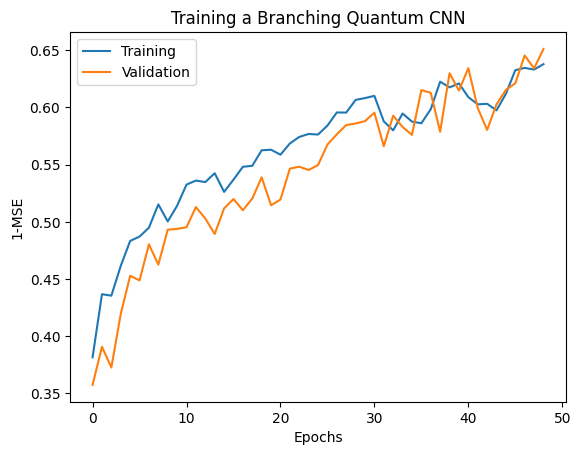

In [36]:
plt.plot(1-np.array(history.history['loss'][1:]), label='Training')
plt.plot(1-np.array(history.history['val_loss'][1:]), label='Validation')
plt.title('Training a Branching Quantum CNN')
plt.xlabel('Epochs')
plt.ylabel('1-MSE')
plt.legend()
plt.show()